# Using MIOFlow to discover cell trajectories in Embryoid Body Data

Goals:
- Understand how to define the cell trajectories path
- Understand some different hyperparameters that defines the MIOFlow trajectory finding algorithm
- Obtain the gene trends in the trajectories

## 0.1 Installing MIOFlow

MIOFlow is available as a PyPi package in: https://pypi.org/project/MIOFlow/

In [ ]:
!pip install MIOFlow

## 0.2 [Optional] Downloading 10X data

### Downloading Data from Mendeley Datasets

The EB dataset is publically available as `scRNAseq.zip` at Mendelay Datasets at <https://data.mendeley.com/datasets/v6n743h5ng/>. 

Inside the scRNAseq folder, there are five subdirectories, and in each subdirectory are three files: `barcodes.tsv`, `genes.tsv`, and `matrix.mtx`. For more information about how CellRanger produces these files, check out the [Gene-Barcode Matrices Documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices).

Make sure to download the files and save them under the `omics_toolbox/data/raw` directory.

Here's the directory structure:
```
data
└── raw
    └── scRNAseq
        ├── scRNAseq.zip
        ├── T0_1A
        │   ├── barcodes.tsv
        │   ├── genes.tsv
        │   └── matrix.mtx
        ├── T2_3B
        │   ├── barcodes.tsv
        │   ├── genes.tsv
        │   └── matrix.mtx
        ├── T4_5C
        │   ├── barcodes.tsv
        │   ├── genes.tsv
        │   └── matrix.mtx
        ├── T6_7D
        │   ├── barcodes.tsv
        │   ├── genes.tsv
        │   └── matrix.mtx
        └── T8_9E
            ├── barcodes.tsv
            ├── genes.tsv
            └── matrix.mtx
└── processed
└── interim
└── external
```



## 0.3 Importing MIOFlow and defining data paths

The first step is to import every necessary package.

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Importing "classic" python packages
import numpy as np   
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Scanpy is a python library used to handle single cell data. (https://scanpy.readthedocs.io/en/stable/)
import scanpy as sc  

# MIOFlow is a Deep Learning algorithm and uses pytorch (https://pytorch.org/)
import torch

# This use_cuda flag verifies that we can use GPUs for training of the algorithm.
# This speeds up the training and inference of the algorithm a lot.
# CUDA is a sofware that was made available by NVIDEA and is widelly used to enable GPU training using pytorch.
use_cuda = torch.cuda.is_available()


# Here we are importing the MIOFlow functions we are going to use later in the notebook
from MIOFlow.mioflow import MIOFlow
from MIOFlow.plots import  plot_losses
from MIOFlow.utils import set_seeds

set_seeds(0)

## Here we are setting the data path
RAW_DATA_DIR = os.path.join('../../data', 'raw')
print(RAW_DATA_DIR)

## 1. Understanding the data

First we will download the data from google drive.
If you want to download your own data, you can just change the file_id to one that you can access and that is in Google Drive.

In [27]:
file_id = "1zNdlGCCwiofY28cYbyv7fx3CQJPB9Omy"
url = f"https://drive.google.com/uc?id={file_id}"
output = "data.h5ad"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1zNdlGCCwiofY28cYbyv7fx3CQJPB9Omy
From (redirected): https://drive.google.com/uc?id=1zNdlGCCwiofY28cYbyv7fx3CQJPB9Omy&confirm=t&uuid=f9c62bde-92df-4277-a6bc-e858d31b1c6b
To: /Users/joaofelipe/Yale/Omics Toolbox/4_Code/omics_toolbox/workshops/cancer_plasticity/mioflow/data.h5ad
100%|██████████| 523M/523M [00:19<00:00, 26.4MB/s] 


'data.h5ad'

Now, let's take a look at our Annotated Data object (anndata).

We downloaded a .h5ad annotated data object that is becoming the default data structure to save single cell data for downstream analysis.

In [28]:
adata = sc.read_h5ad("data.h5ad")
adata

AnnData object with n_obs × n_vars = 16985 × 21465
    obs: 'n_counts', 'batch', 'day', 'new', 'sample_id', 'growth', 'log_growth', 'sample_labels', 'louvain', 'S_score', 'G2M_score', 'phase', 'emt_scores'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'is_emt'
    uns: 'emt_weights', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'sample_id_colors'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Here you can see that our adata object contains a lot of fields. They are described as follows:

**Basic Structure**
- *adata.X*: 16,985 observations (cells) × 21,465 variables (genes)

**Observation Metadata (`.obs`)**
- *n_counts*: Total number of counts per cell (library size)
- *batch*: Batch information for identifying experimental batches
- *day*: Time point or day of sample collection
- *new*: Binary indicator for new vs. existing samples
- *sample_id*: Unique identifier for each sample
- *growth*: Growth rate measurements
- *log_growth*: Log-transformed growth rate values
- *sample_labels*: Descriptive labels for samples
- *louvain*: Louvain clustering results for cell type identification
- *S_score*: Cell cycle S phase score
- *G2M_score*: Cell cycle G2/M phase score
- *phase*: Assigned cell cycle phase (G1, S, G2M)
- *emt_scores*: Epithelial-mesenchymal transition (EMT) scores

**Variable Metadata (`.var`)**
- *gene_ids*: Gene identifiers or symbols
- *feature_types*: Type of genomic feature (e.g., Gene Expression)
- *genome*: Reference genome information
- *n_counts*: Total counts per gene across all cells
- *is_emt*: Boolean indicator for EMT-related genes

**Unstructured Data (`.uns`)**
- *emt_weights*: Weights used for EMT scoring
- *louvain*: Parameters and results from Louvain clustering
- *louvain_colors*: Color palette for Louvain clusters
- *neighbors*: Neighbor graph parameters and metadata
- *pca*: Principal component analysis parameters and metadata
- *phase_colors*: Color palette for cell cycle phases
- *sample_id_colors*: Color palette for sample identifiers

**Multi-dimensional Observations (`.obsm`)**
- *X_pca*: Principal component analysis coordinates (cell embeddings)
- *X_phate*: PHATE dimensionality reduction coordinates

**Multi-dimensional Variables (`.varm`)**
- *PCs*: Principal component loadings (gene loadings)

**Pairwise Observations (`.obsp`)**
- *connectivities*: Cell-cell connectivity matrix (sparse)
- *distances*: Cell-cell distance matrix (sparse)

# 2. Choosing a feature to find trajectories

We want our trajectories to follow some dynamics that we want to discover trends about.
Let's start by looking at our PHATE space. This is the latent space we want to find trajectories in.

<Axes: >

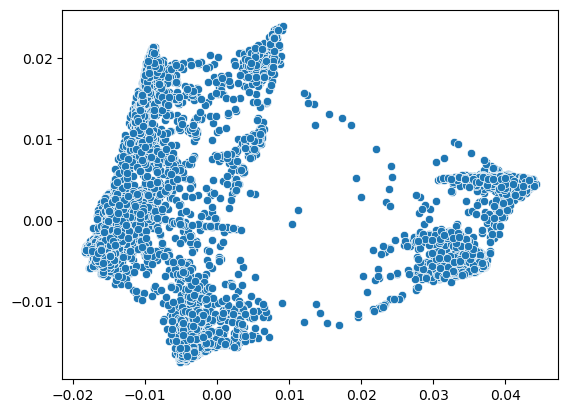

In [29]:
sns.scatterplot(x=adata.obsm['X_phate'][:,0],y=adata.obsm['X_phate'][:,1]) # Ploting the first and second phate components

Now, we need to choose a feature to "guide" our space. Let's check the avalable features:

In [30]:
adata.obs

n_counts batch   day  new sample_id    growth  \
AAACCTGAGTTCGCGC-1-4   12874.0     4   0.0    0         0  1.247017   
AAACCTGCAGGACCCT-1-4   12520.0     4   0.0    0         0  0.459218   
AAACCTGCATGTTGAC-1-4   10850.0     4   0.0    0         0  0.545286   
AAACCTGGTCGAACAG-1-4    8351.0     4   0.0    0         0  1.386842   
AAACCTGTCCGTTGCT-1-4    7429.0     4   0.0    0         0  0.067749   
...                        ...   ...   ...  ...       ...       ...   
TTTGGTTTCCGCTGTT-1-8    6701.0     8  30.0    0        30       NaN   
TTTGGTTTCTGCGGCA-1-8   10274.0     8  30.0    0        30       NaN   
TTTGTCACAGTCTTCC-1-8   21244.0     8  30.0    0        30       NaN   
TTTGTCAGTACTTGAC-1-8   23182.0     8  30.0    0        30       NaN   
TTTGTCAGTTCCACGG-1-8   12970.0     8  30.0    0        30       NaN   

                      log_growth  sample_labels louvain   S_score  G2M_score  \
AAACCTGAGTTCGCGC-1-4    0.318481              0       5  0.104677   0.249283   
AAACCTGCAGGACCCT-1-4   -1.122749              0       6  0.109079  -0.014701   
AAACCTGCATGTTGAC-1-4   -0.874916              0       5 -0.131493  -0.394984   
AAACCTGGTCGAACAG-1-4    0.471803              0       5 -0.009297  -0.205679   
AAACCTGTCCGTTGCT-1-4   -3.883659              0       5 -0.117484  -0.235224   
...                          ...            ...     ...       ...        ...   
TTTGGTTTCCGCTGTT-1-8         NaN              4      11  0.192874   0.153021   
TTTGGTTTCTGCGGCA-1-8         NaN              4       2 -0.122540  -0.210936   
TTTGTCACAGTCTTCC-1-8         NaN              4       2  0.152778  -0.151314   
TTTGTCAGTACTTGAC-1-8         NaN              4       2 -0.113618  -0.293476   
TTTGTCAGTTCCACGG-1-8         NaN              4       2  0.545617   0.110114   

                     phase  emt_scores  
AAACCTGAGTTCGCGC-1-4   G2M    0.244868  
AAACCTGCAGGACCCT-1-4     S    6.117601  
AAACCTGCATGTTGAC-1-4    G1    0.828480  
AAACCTGGTCGAACAG-1-4    G1   -0.143657  
AAACCTGTCCGTTGCT-1-4    G1   -0.236617  
...                    ...         ...  
TTTGGTTTCCGCTGTT-1-8     S   -0.381007  
TTTGGTTTCTGCGGCA-1-8    G1   -0.418274  
TTTGTCACAGTCTTCC-1-8     S    0.455980  
TTTGTCAGTACTTGAC-1-8    G1   -0.614758  
TTTGTCAGTTCCACGG-1-8     S    0.324958  

[16985 rows x 13 columns]

We can see that we have: n_counts, batch, day, growth, louvain, etc ...

Let's color by different features.

<Axes: >

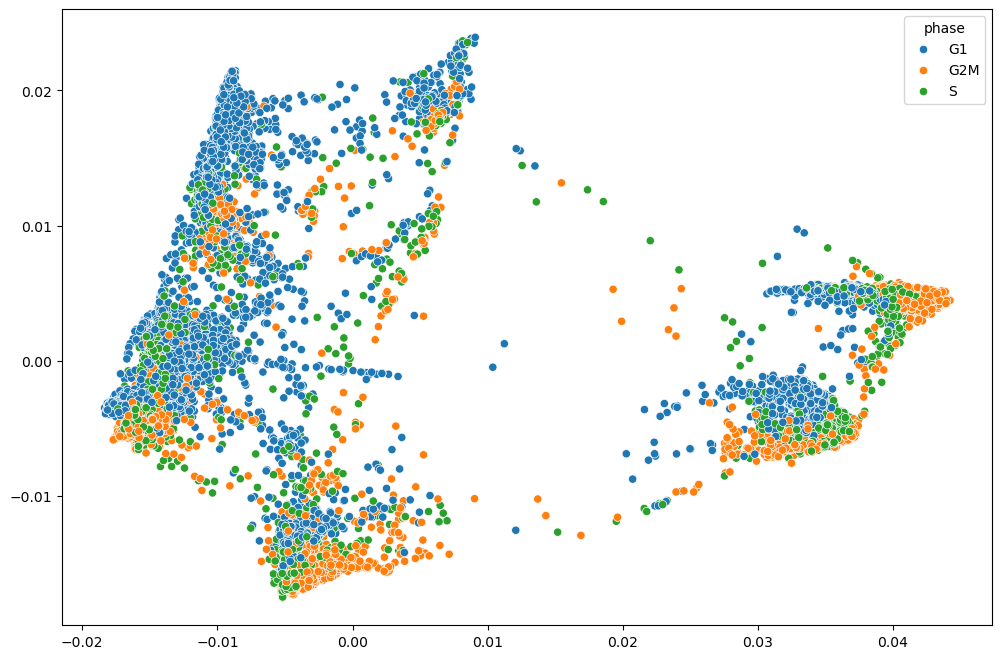

In [31]:
fig = plt.figure(figsize=(12, 8))
# Try playing around and change the _hue_ of the data. ex.: louvain, phase, day, log_growth, ...
sns.scatterplot(x=adata.obsm['X_phate'][:,0],y=adata.obsm['X_phate'][:,1], hue=adata.obs['phase'])

In our case, we know we want to get trajectories over the time samples of our cancer collected data.

We want trajectories that go from the initial sample all the way to the final time point, while following the data structure (manifold)

So we will use the 'day'

<Axes: >

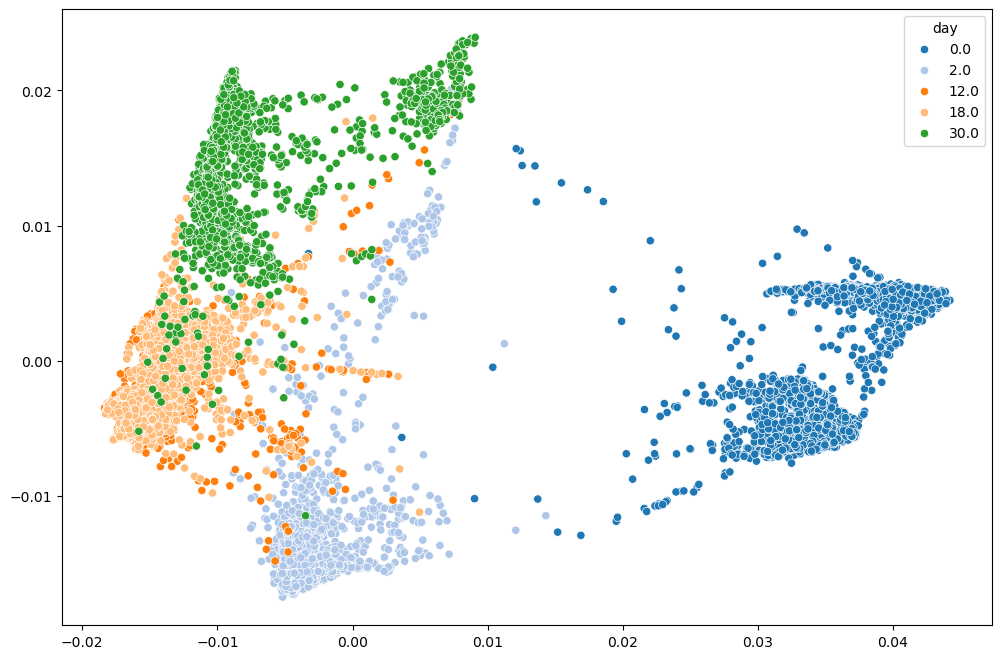

In [32]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(x=adata.obsm['X_phate'][:,0],y=adata.obsm['X_phate'][:,1], hue=adata.obs['day'],palette='tab20')

# 3. Preparing the data to MIOFlow

The MIOFlow algorithm expects data in a standart format, so we cannot simply send our adata directly to the algorithm.
THe algorithm expects a well structured dataframe, where it will work on top to discover the trajectories.

The first step is creating a new DataFrame, that contains only the embeddings dimensions (from PHATE).

The second step is creating a "samples" columns that contains the feature we want to find trajectories over. This samples column need to be discrete (onlyy integers are accepted)

This is done as follows:

In [33]:
# Create a numerical bin for each unique value (day 0 -> 0, day 2 -> 1, day 12 -> 2, day 18 -> 3, day 30 -> 4)
adata.obs['discrete_time'], _ = pd.factorize(adata.obs['day'])

#Now lets create the DataFrame with only two columns, each with a name for the dimensions (d1,d2)
mioflow_df = pd.DataFrame(adata.obsm['X_phate'], columns=[f'd{i}' for i in range(1, adata.obsm['X_phate'].shape[1]+1)])

# Add the time labels to the dataframe as a column called 'samples' (this is expected by MIOFlow)
mioflow_df['samples'] = adata.obs['discrete_time'].values
mioflow_df

d1        d2  samples
0      0.036356 -0.005683        0
1      0.039413  0.000519        0
2      0.034858 -0.003345        0
3      0.030872 -0.004870        0
4      0.034578 -0.002362        0
...         ...       ...      ...
16980  0.004354  0.017672        4
16981 -0.007092  0.008804        4
16982 -0.012404  0.003051        4
16983 -0.012093  0.009553        4
16984 -0.010340  0.011660        4

[16985 rows x 3 columns]

Perfect! We have the necessary input for MIOFlow. Let's do a final check that this data contains everything we want to infer on top.

<Axes: xlabel='d1', ylabel='d2'>

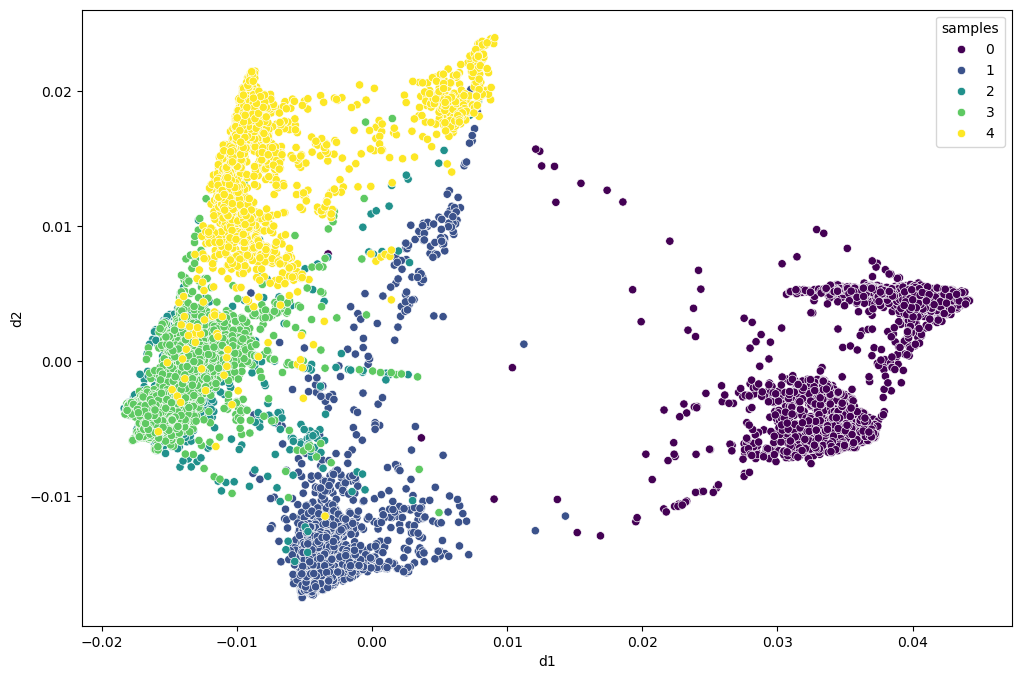

In [34]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(data=mioflow_df, x='d1', y='d2', hue='samples', palette='viridis')

If your data looks right, and we can see a path for the trajectories to follow, we can move on to training the MIOFlow algorithm.

# 4. The MIOFlow Model

## 4.1 Defining the hyperparameters
The MIOFlow algorithm has a lot of hyperparameters to be chosen.
Most of the default ones were picked to work just fine for most use cases.
If you are just running the algorithm by yourself, some of this parameters do not need to be defined.

However, we wanted to show all the possible changes you could make to the algorithm. The configurations are described in the next code block.

In [35]:
# =============================================================================
# MIOFlow Training Configuration
# =============================================================================

# =============================================================================
# MODEL CONFIGURATION
# =============================================================================
MODEL_CONFIG = {
    'layers': [16, 32, 16],           # Neural network architecture
    'activation': 'CELU',             # Activation function
    'scales': None,                   # SDE scales (None for default)
    'use_cuda': use_cuda,             # GPU usage
}

# =============================================================================
# TRAINING STRUCTURE CONFIGURATION
# =============================================================================
TRAINING_STRUCTURE = {
    'n_local_epochs': 40,             # Local training epochs (phase 1)
    'n_epochs': 40,                   # Global training epochs (main phase)
    'n_post_local_epochs': 0,         # Post-local training epochs (phase 3)
}

# =============================================================================
# OPTIMIZATION CONFIGURATION
# =============================================================================
OPTIMIZATION_CONFIG = {
    'criterion_type': 'ot',           # Loss criterion type ('ot' = optimal transport)
    'use_density_loss': True,         # Enable density loss (KNN-based)
    'lambda_density': 20,             # Weight for density loss
}

# =============================================================================
# DATA CONFIGURATION
# =============================================================================
DATA_CONFIG = {
    'hold_one_out': False,            # Holdout one timepoint for validation
    'sample_size': 100,               # Batch size will be the minimum between 
                                      # this and the actual minimum count for a sample
    'reverse_schema': True,           # Use reverse trajectories for training
    'reverse_n': 2,                   # Number of reverse trajectories
}

# =============================================================================
# ADVANCED FEATURES (typically not used for single-cell data)
# =============================================================================
ADVANCED_CONFIG = {
    'autoencoder': None,              # GeodesicAutoencoder (None = disabled)
    'use_emb': False,                 # Use embeddings
    'use_gae': False,                 # Use Geodesic AutoEncoder
}

# =============================================================================
# VISUALIZATION AND OUTPUT
# =============================================================================
OUTPUT_CONFIG = {
    'exp_dir': '.',                   # Experiment directory
    'plot_every': None,               # Plot frequency during training
    'n_points': 100,                  # Number of points for visualization
    'n_trajectories': 100,            # Number of trajectories for visualization
    'n_bins': 100,                    # Number of bins for discretization
}

### 4.2 Creating the MIOFlow operator
Now, we just need to pass all our data, the mioflow_df and the configurations into our MIOFlow algorithm.

You'll see that we need to pass both our adata and the mioflow_df. 
This is necessary for the algorithm to retrieve gene trends in the end.

In [36]:
# =============================================================================
# INITIALIZE MIOFLOW WITH CONFIG DICTIONARIES
# =============================================================================

mioflow_operator = MIOFlow(
    adata,
    input_df=mioflow_df,
    obsm_key="X_phate",
    debug_level='info',

    model_config=MODEL_CONFIG,  # Pass the model configs as a single parameter

    # Unpack all configurations
    **TRAINING_STRUCTURE,
    **OPTIMIZATION_CONFIG,
    **DATA_CONFIG,
    **ADVANCED_CONFIG,
    **OUTPUT_CONFIG,
)

2025-08-19 21:34:18,806 - MIOFlow - INFO - MIOFlow initialized with 16985 cells and 21465 genes
2025-08-19 21:34:18,807 - MIOFlow - INFO - Output directory: .


## 4.3 Training the algorithm

In [37]:
## THIS STEP SHOULD TAKE AROUND 5 MINUTES !
# Fit the model with the configurations
mioflow = mioflow_operator.fit()

2025-08-19 21:34:18,812 - MIOFlow - INFO - Starting MIOFlow fitting
2025-08-19 21:34:18,825 - MIOFlow - INFO - Training with structure: {'n_local_epochs': 40, 'n_epochs': 40, 'n_post_local_epochs': 0}
2025-08-19 21:34:18,825 - MIOFlow - INFO - Using CUDA: False
Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/joaofelipe/miniconda3/envs/omics-toolbox/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /Users/joaofelipe/Yale/Omics Toolbox/4_Code/omics_toolbox/workshops/cancer_plasticity/mioflow/checkpoints exists and is not empty.

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | net     | Sequential | 2.9 K  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estima

Training PHATE Autoencoder with 16985 cells and 2 dimensions


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


Training MIOFlow trajectory inference model


Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

/Users/joaofelipe/Yale/Omics Toolbox/4_Code/MIOFlow/MIOFlow/train.py:265: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  batch_loss = torch.Tensor(batch_loss).float()


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

2025-08-19 21:36:46,750 - MIOFlow - INFO - MIOFlow fitting completed successfully


## 4.4 Observing the training loss

The loss functions need to go down during training, this means that our algorithm is learning on each new data point it's passing by

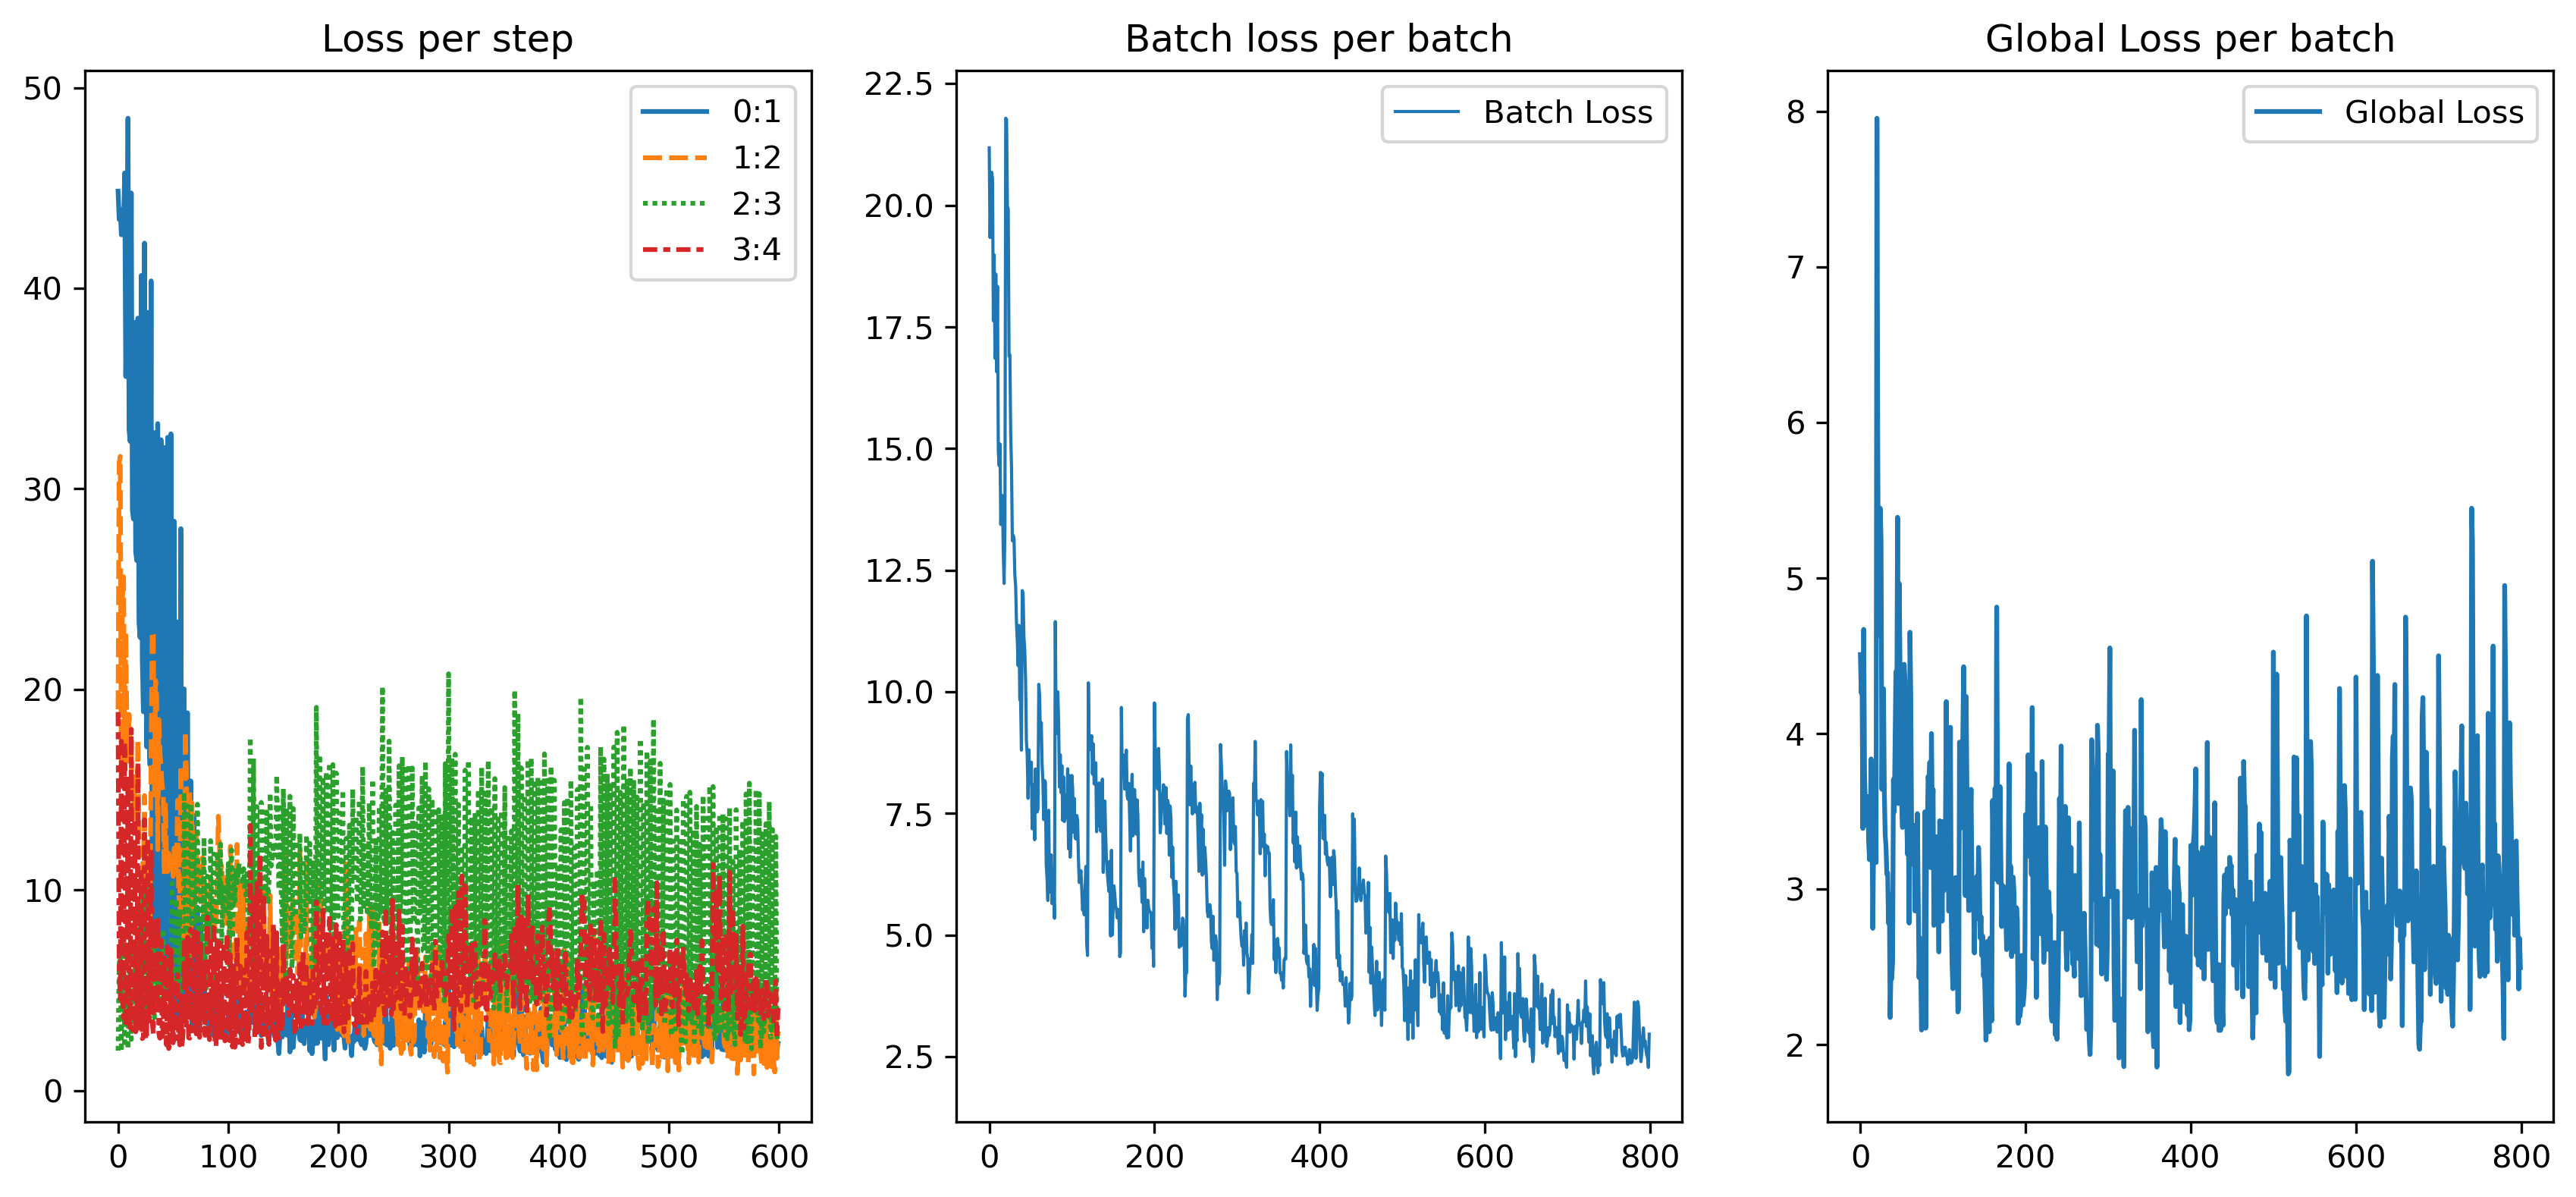

In [38]:
plot_losses(
    mioflow.local_losses, 
    mioflow.batch_losses, 
    mioflow.globe_losses, 
)

## 4.5 Visualizing the MIOFlow Outputs

The MIOFlow object contains every information needed after traning.
Our trajectories where saved under:
```mioflow.trajectories```

In [39]:
mioflow.trajectories.shape # The trajectories have the shape (n_trajectories, n_points, n_dimensions)

(100, 100, 2)

In [40]:
trajectoriespts = mioflow.trajectories * mioflow.std_vals + mioflow.mean_vals
true_data = mioflow.df[[f'd{i}' for i in range(1, len(mioflow.df.columns))]] * mioflow.std_vals + mioflow.mean_vals

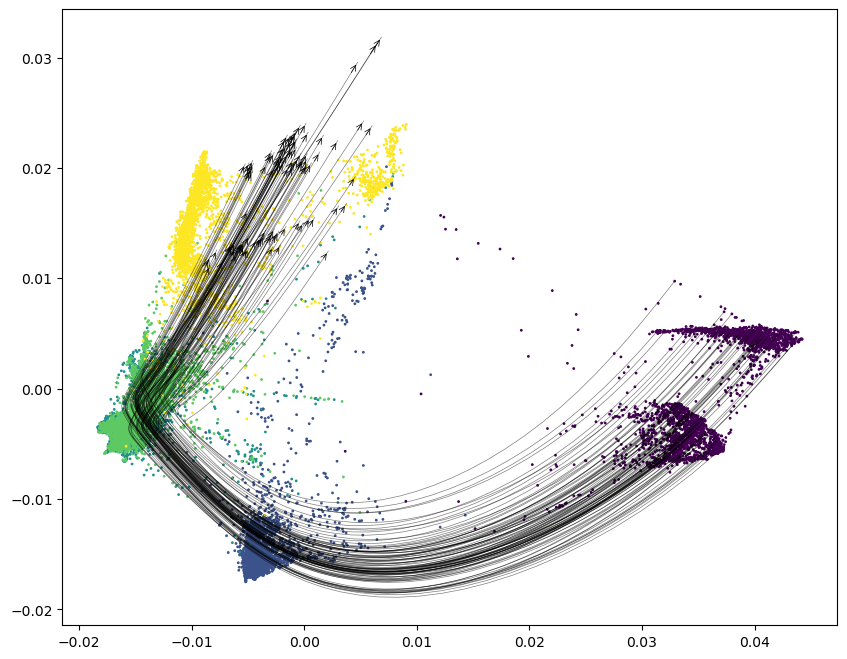

In [41]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(true_data.values[:, 0], true_data.values[:, 1], c=mioflow.df['samples'].values, cmap='viridis', s=1)
for i,traj in enumerate(np.transpose(trajectoriespts, axes=(1,0,2))):
    # widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black')
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle='->', color='Black', lw=.5, mutation_scale=10))

# 5. Decoding back to gene space

The interest of finding these trajectories in PHATE space is that now we can decode our trajectories back to gene space.

This way we can understand how they behave in terms of the real gene trends.

The function: ```mioflow.decode_to_gene_space()``` will take our trajectories and return them in the gene space based to mioflow with our adata.

In [42]:
trajectories_gene_space = mioflow.decode_to_gene_space()

In [43]:
trajectories_gene_space.shape # this has the shape (n_trajectories,n_points,n_genes)

(100, 100, 21465)

Now, let's choose some genes to visualize how they change in our trajectory. 
Scanpy has a function where we can retrieve the top_n genes that varies a lot in our data. 
Let's focus on those first. You can then just play with genes you are interested in.

In [44]:
sc.pp.highly_variable_genes(adata, n_top_genes=25) # this create a boolean mask saying if a gene is in the top 25 highly variable genes or not.

example_genes = adata.var_names[adata.var['highly_variable']] # Let's select only the columns that are highly variable
print(example_genes)
example_gene_mask = adata.var_names.isin(example_genes)

Index(['PRAMEF1', 'PRAMEF13', 'CYR61', 'HSPA6', 'EIF4A2', 'CXCL1', 'CXCL14',
       'AL031058.1', 'SOX4', 'HSPA1A', 'CTGF', 'ADM', 'MMP7', 'MMP13', 'KRT18',
       'CCNA1', 'NFKBIA', 'RBBP6', 'MT1E', 'RRAD', 'RASD1', 'JPT1', 'WFDC2',
       'MBD3L5', 'DUXA'],
      dtype='object')


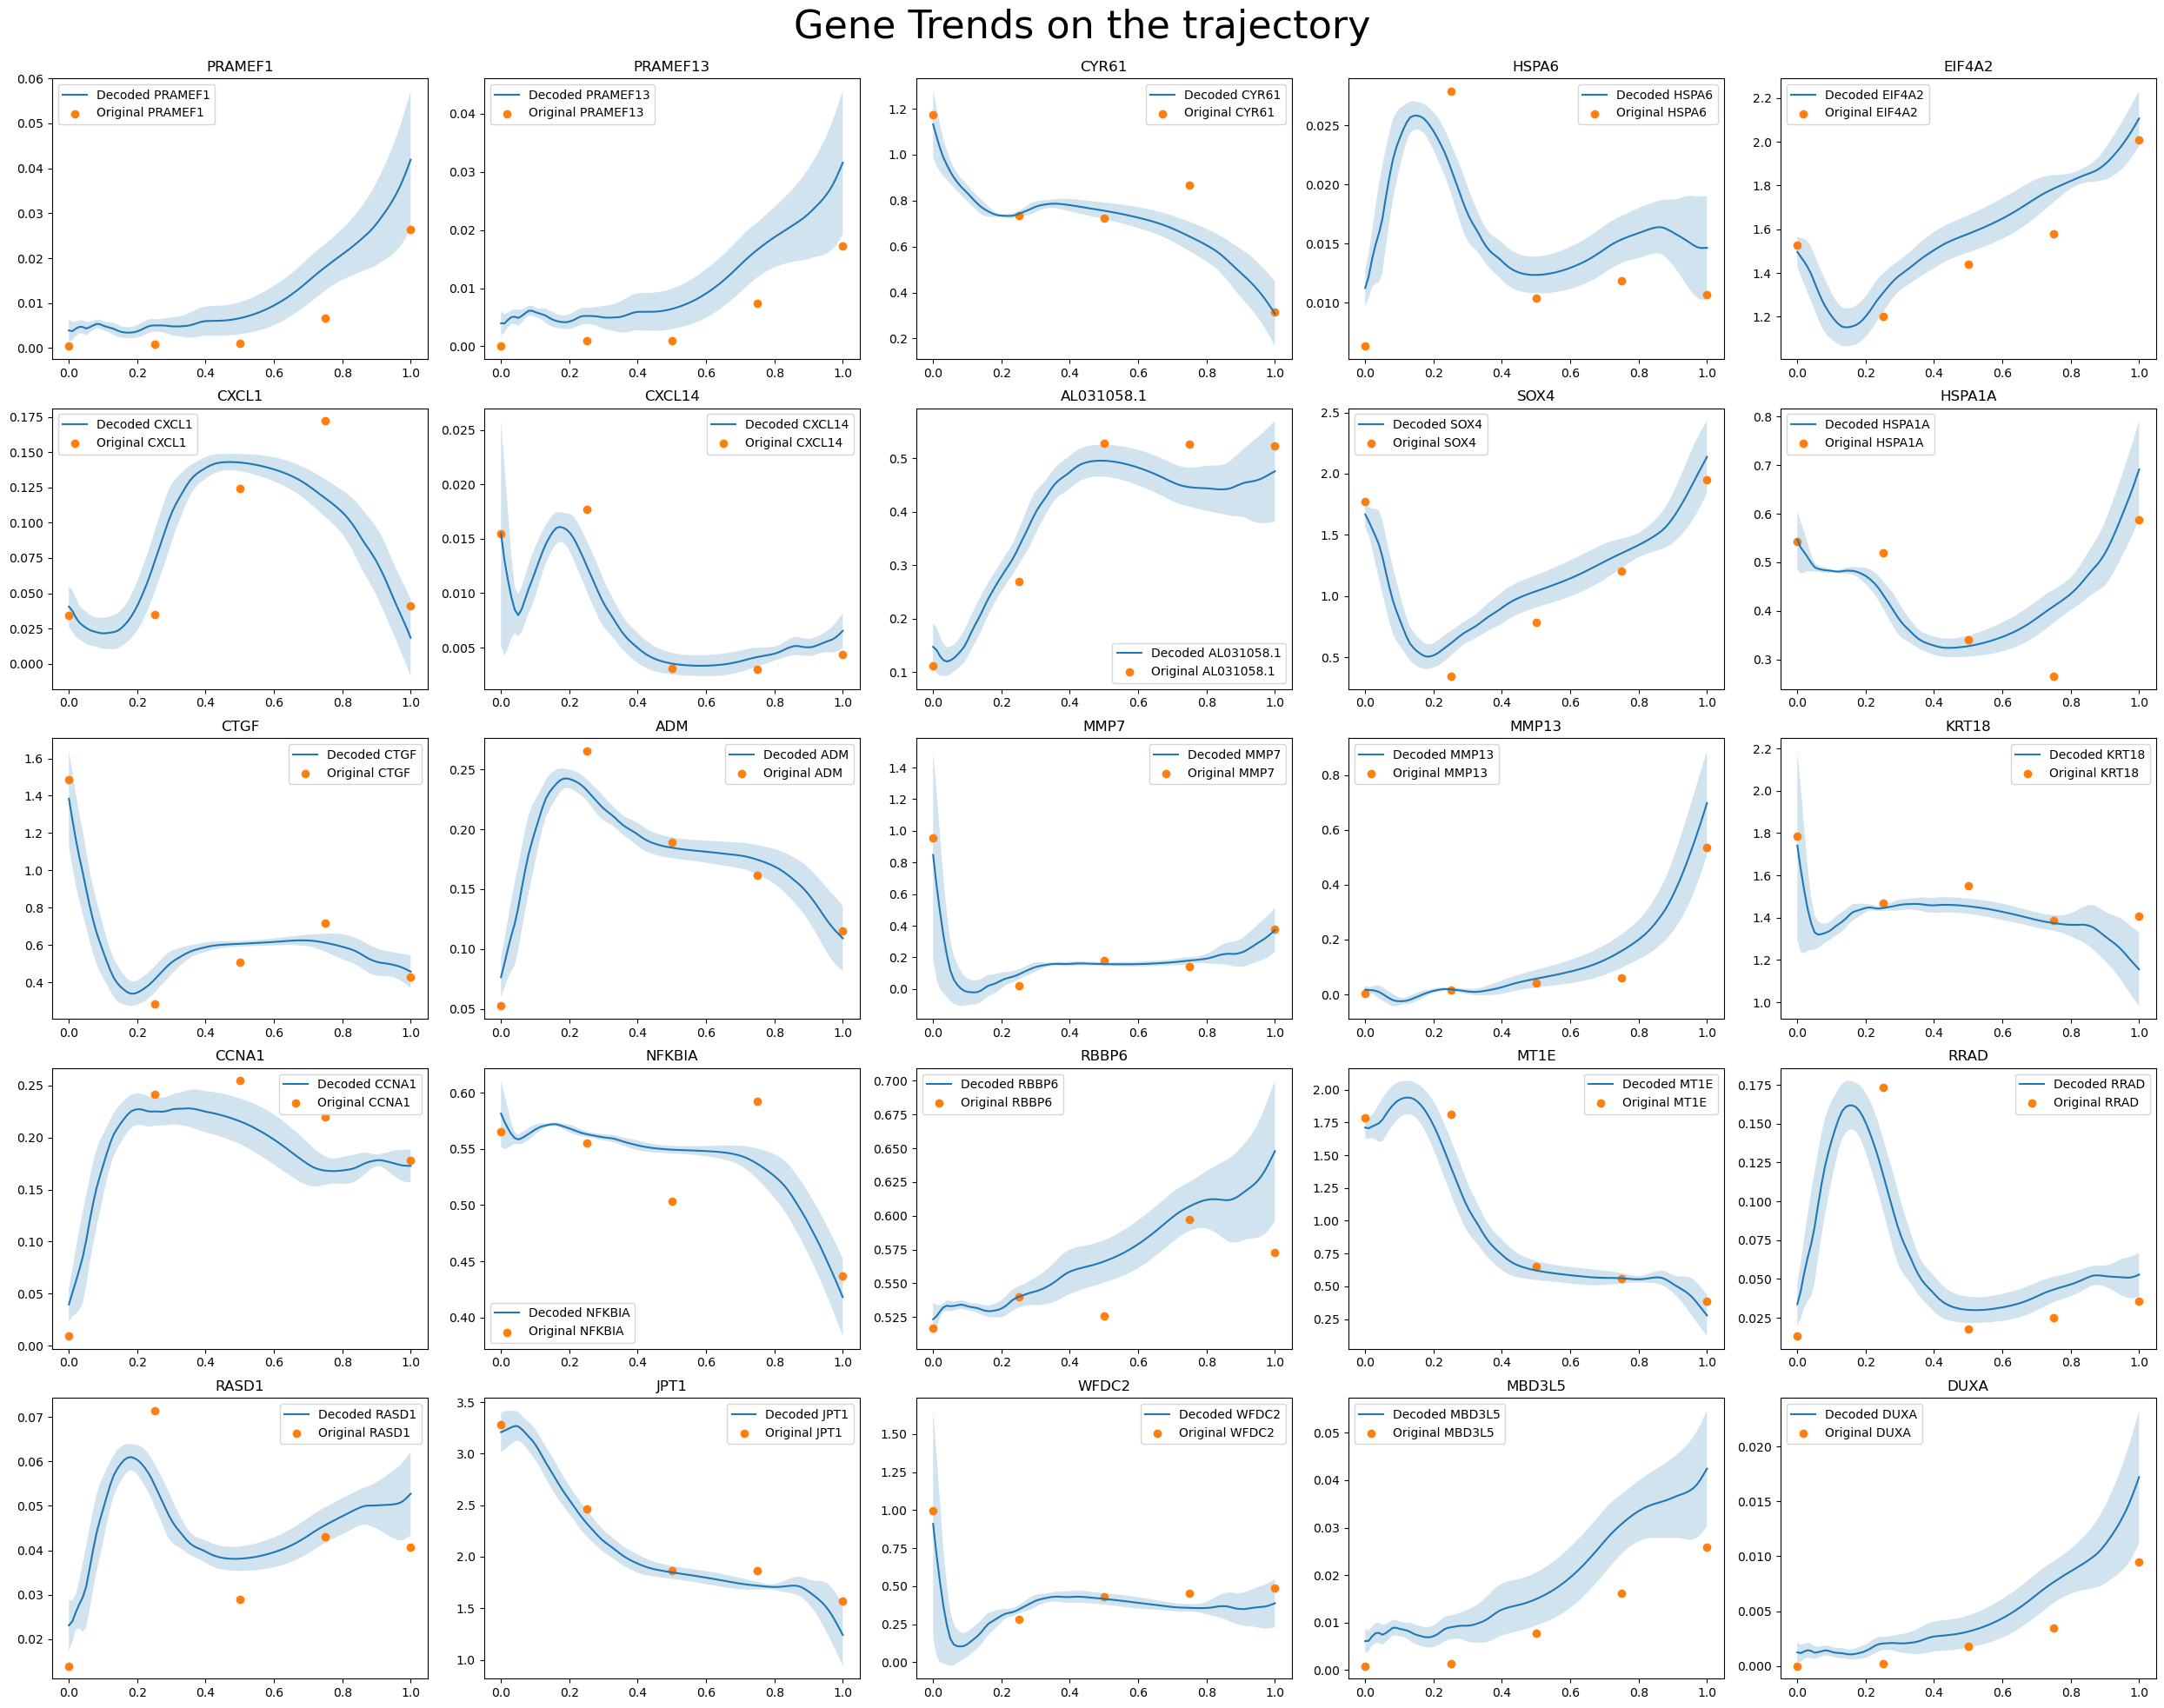

In [45]:
# Retrieving interest genes
adata_example_gene = adata[:, example_gene_mask]
decoded_example_gene = trajectories_gene_space[:, :, example_gene_mask]
decoded_example_gene_mean = decoded_example_gene.mean(axis=1)
decoded_example_gene_std = decoded_example_gene.std(axis=1)

# Setting the y axis to be through the entire trajectory
x_time = np.linspace(0, 1, traj.shape[0])
x_time_data = adata_example_gene.obs['discrete_time']
x_time_data = (x_time_data - x_time_data.min()) / (x_time_data.max() - x_time_data.min())

# Filtering the data to only show the genes of interest
data_df = pd.DataFrame(adata_example_gene.X.toarray(), columns=example_genes, index=adata_example_gene.obs_names)
data_df['x_time'] = x_time_data
data_mean = data_df.groupby('x_time').mean()
data_std = data_df.groupby('x_time').std()

# Plotting all genes in a grid
# For this we need to know how many genes we have
n_genes = decoded_example_gene_mean.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = int(np.ceil(n_genes / n_rows))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Finally, we plot each gene in a subplot
## The plots have the mean of the decoded gene over all trajectories in blue and the shade is the variance
for i in range(n_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_example_gene_mean[:,i], label=f'Decoded {example_genes[i].split("_Cycle")[-1]}')
    ax.fill_between(x_time, decoded_example_gene_mean[:,i] - decoded_example_gene_std[:,i], decoded_example_gene_mean[:,i] + decoded_example_gene_std[:,i], alpha=0.2)
    ax.scatter(data_mean.index, data_mean[example_genes[i]], label=f'Original {example_genes[i].split("_Cycle")[-1]}')
    ax.legend()
    ax.set_title(example_genes[i])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.94)  # Leave space at top
plt.suptitle('Gene Trends on the trajectory', fontsize=32)  # Position suptitle in the space

plt.show()

## Visualizing a single interest gene

If you have a specific gene you want to investigate, the steps should be as easy as the ones above. The only difference is that you need to select a single interest_gene to use as mask. Here is some code so you can investigate a specific marker of interest.

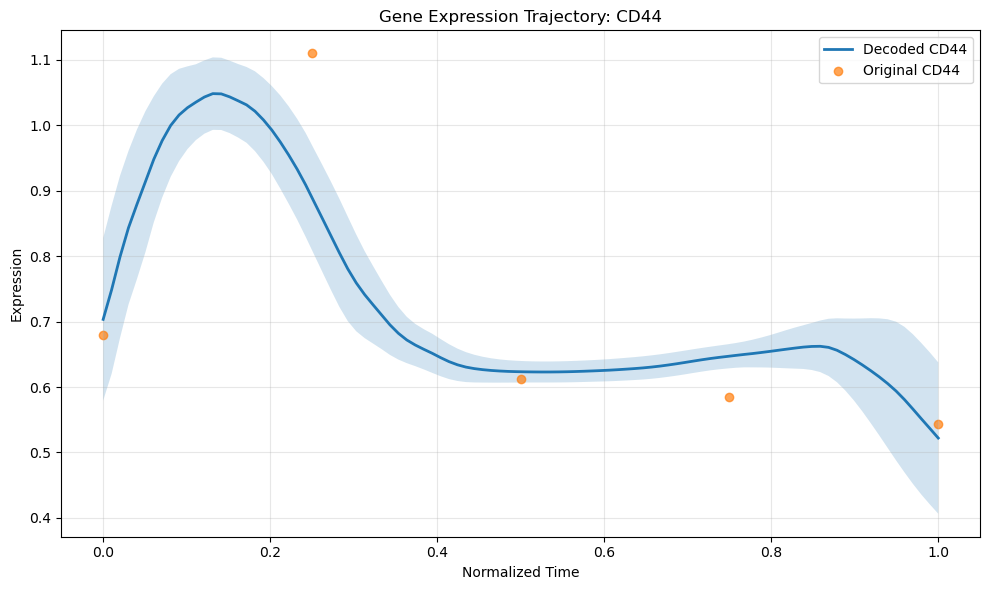

In [46]:
# Pick gene of interest
interest_gene = 'CD44'

# Get gene data
gene_mask = adata.var_names.isin([interest_gene])
gene_data = adata[:, gene_mask]

# Decoded trajectory data
decoded_data = trajectories_gene_space[:, :, gene_mask]
decoded_mean = decoded_data.mean(axis=1).flatten()
decoded_std = decoded_data.std(axis=1).flatten()

# Time normalization
x_time = np.linspace(0, 1, len(decoded_mean))
obs_time = gene_data.obs['discrete_time']
obs_time_norm = (obs_time - obs_time.min()) / (obs_time.max() - obs_time.min())

# Original data aggregation
orig_df = pd.DataFrame({
    'expression': gene_data.X.toarray().flatten(),
    'time': obs_time_norm
})
orig_mean = orig_df.groupby('time')['expression'].mean()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_time, decoded_mean, label=f'Decoded {interest_gene}', linewidth=2)
ax.fill_between(x_time, decoded_mean - decoded_std, decoded_mean + decoded_std, alpha=0.2)
ax.scatter(orig_mean.index, orig_mean.values, label=f'Original {interest_gene}', alpha=0.7)

ax.set_xlabel('Normalized Time')
ax.set_ylabel('Expression')
ax.set_title(f'Gene Expression Trajectory: {interest_gene}')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Focusing on a specific trajectory

The above cells are looking into the average between all the trajectories in our data.
In our case, we know that some trajectories are more related to apoptosis and other to different proceses.

For this, let's look into specific trajectories.

## 6.1 Trajectory closer to the left

Target: (-0.006, 0.02)
Selected trajectory 7 at (-0.01, 0.02)


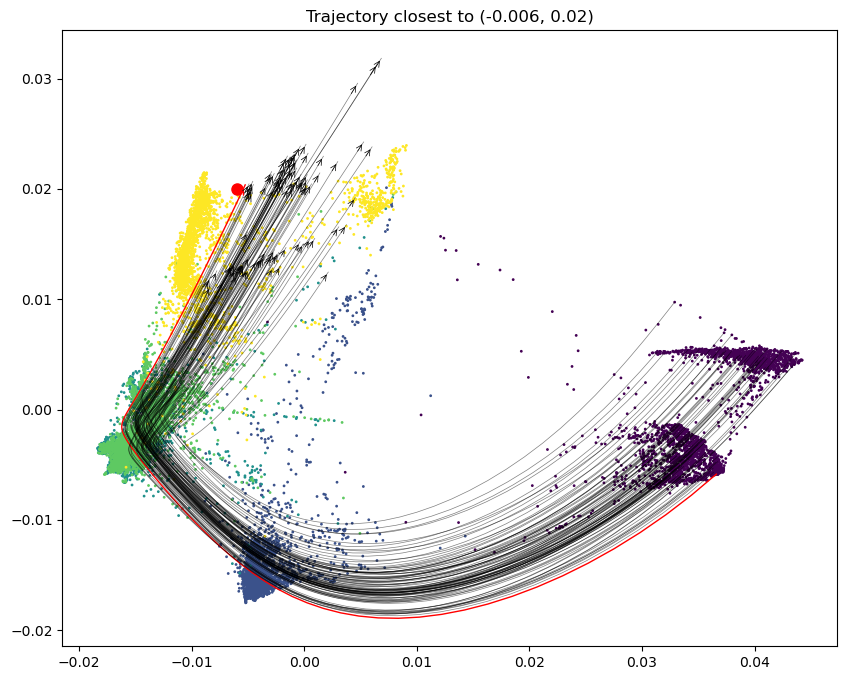

In [81]:
# Choose trajectory based on arrow's x and y coordinates
target_x = -0.006  # Target x-coordinate
target_y = 0.02 # Target y-coordinate

fig = plt.figure(figsize=(10, 8))
plt.scatter(true_data.values[:, 0], true_data.values[:, 1], 
           c=mioflow.df['samples'].values, cmap='viridis', s=1)

# Find trajectory with arrow closest to target point (target_x, target_y)
arrow_positions = []
distances = []
for i, traj in enumerate(np.transpose(trajectoriespts, axes=(1,0,2))):
    arrow_x = traj[-1, 0]  # x-coordinate of arrow (end point)
    arrow_y = traj[-1, 1]  # y-coordinate of arrow (end point)
    arrow_positions.append((arrow_x, arrow_y))
    
    # Calculate Euclidean distance to target point
    distance = np.sqrt((arrow_x - target_x)**2 + (arrow_y - target_y)**2)
    distances.append(distance)

# Find closest trajectory
highlight_trajectory = distances.index(min(distances))

print(f"Target: ({target_x}, {target_y})")
print(f"Selected trajectory {highlight_trajectory} at ({arrow_positions[highlight_trajectory][0]:.2f}, {arrow_positions[highlight_trajectory][1]:.2f})")

for i, traj in enumerate(np.transpose(trajectoriespts, axes=(1,0,2))):
    if i == highlight_trajectory:
        color = 'red'
        linewidth = 1.0
        alpha = 1.0
    else:
        color = 'black'
        linewidth = 0.5
        alpha = 0.5
    
    plt.plot(traj[:, 0], traj[:, 1], alpha=alpha, linewidth=linewidth, color=color)
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle='->', color=color, lw=linewidth, mutation_scale=10))

# Mark target point
plt.plot(target_x, target_y, 'ro', markersize=8)
plt.title(f'Trajectory closest to ({target_x}, {target_y})')
plt.show()

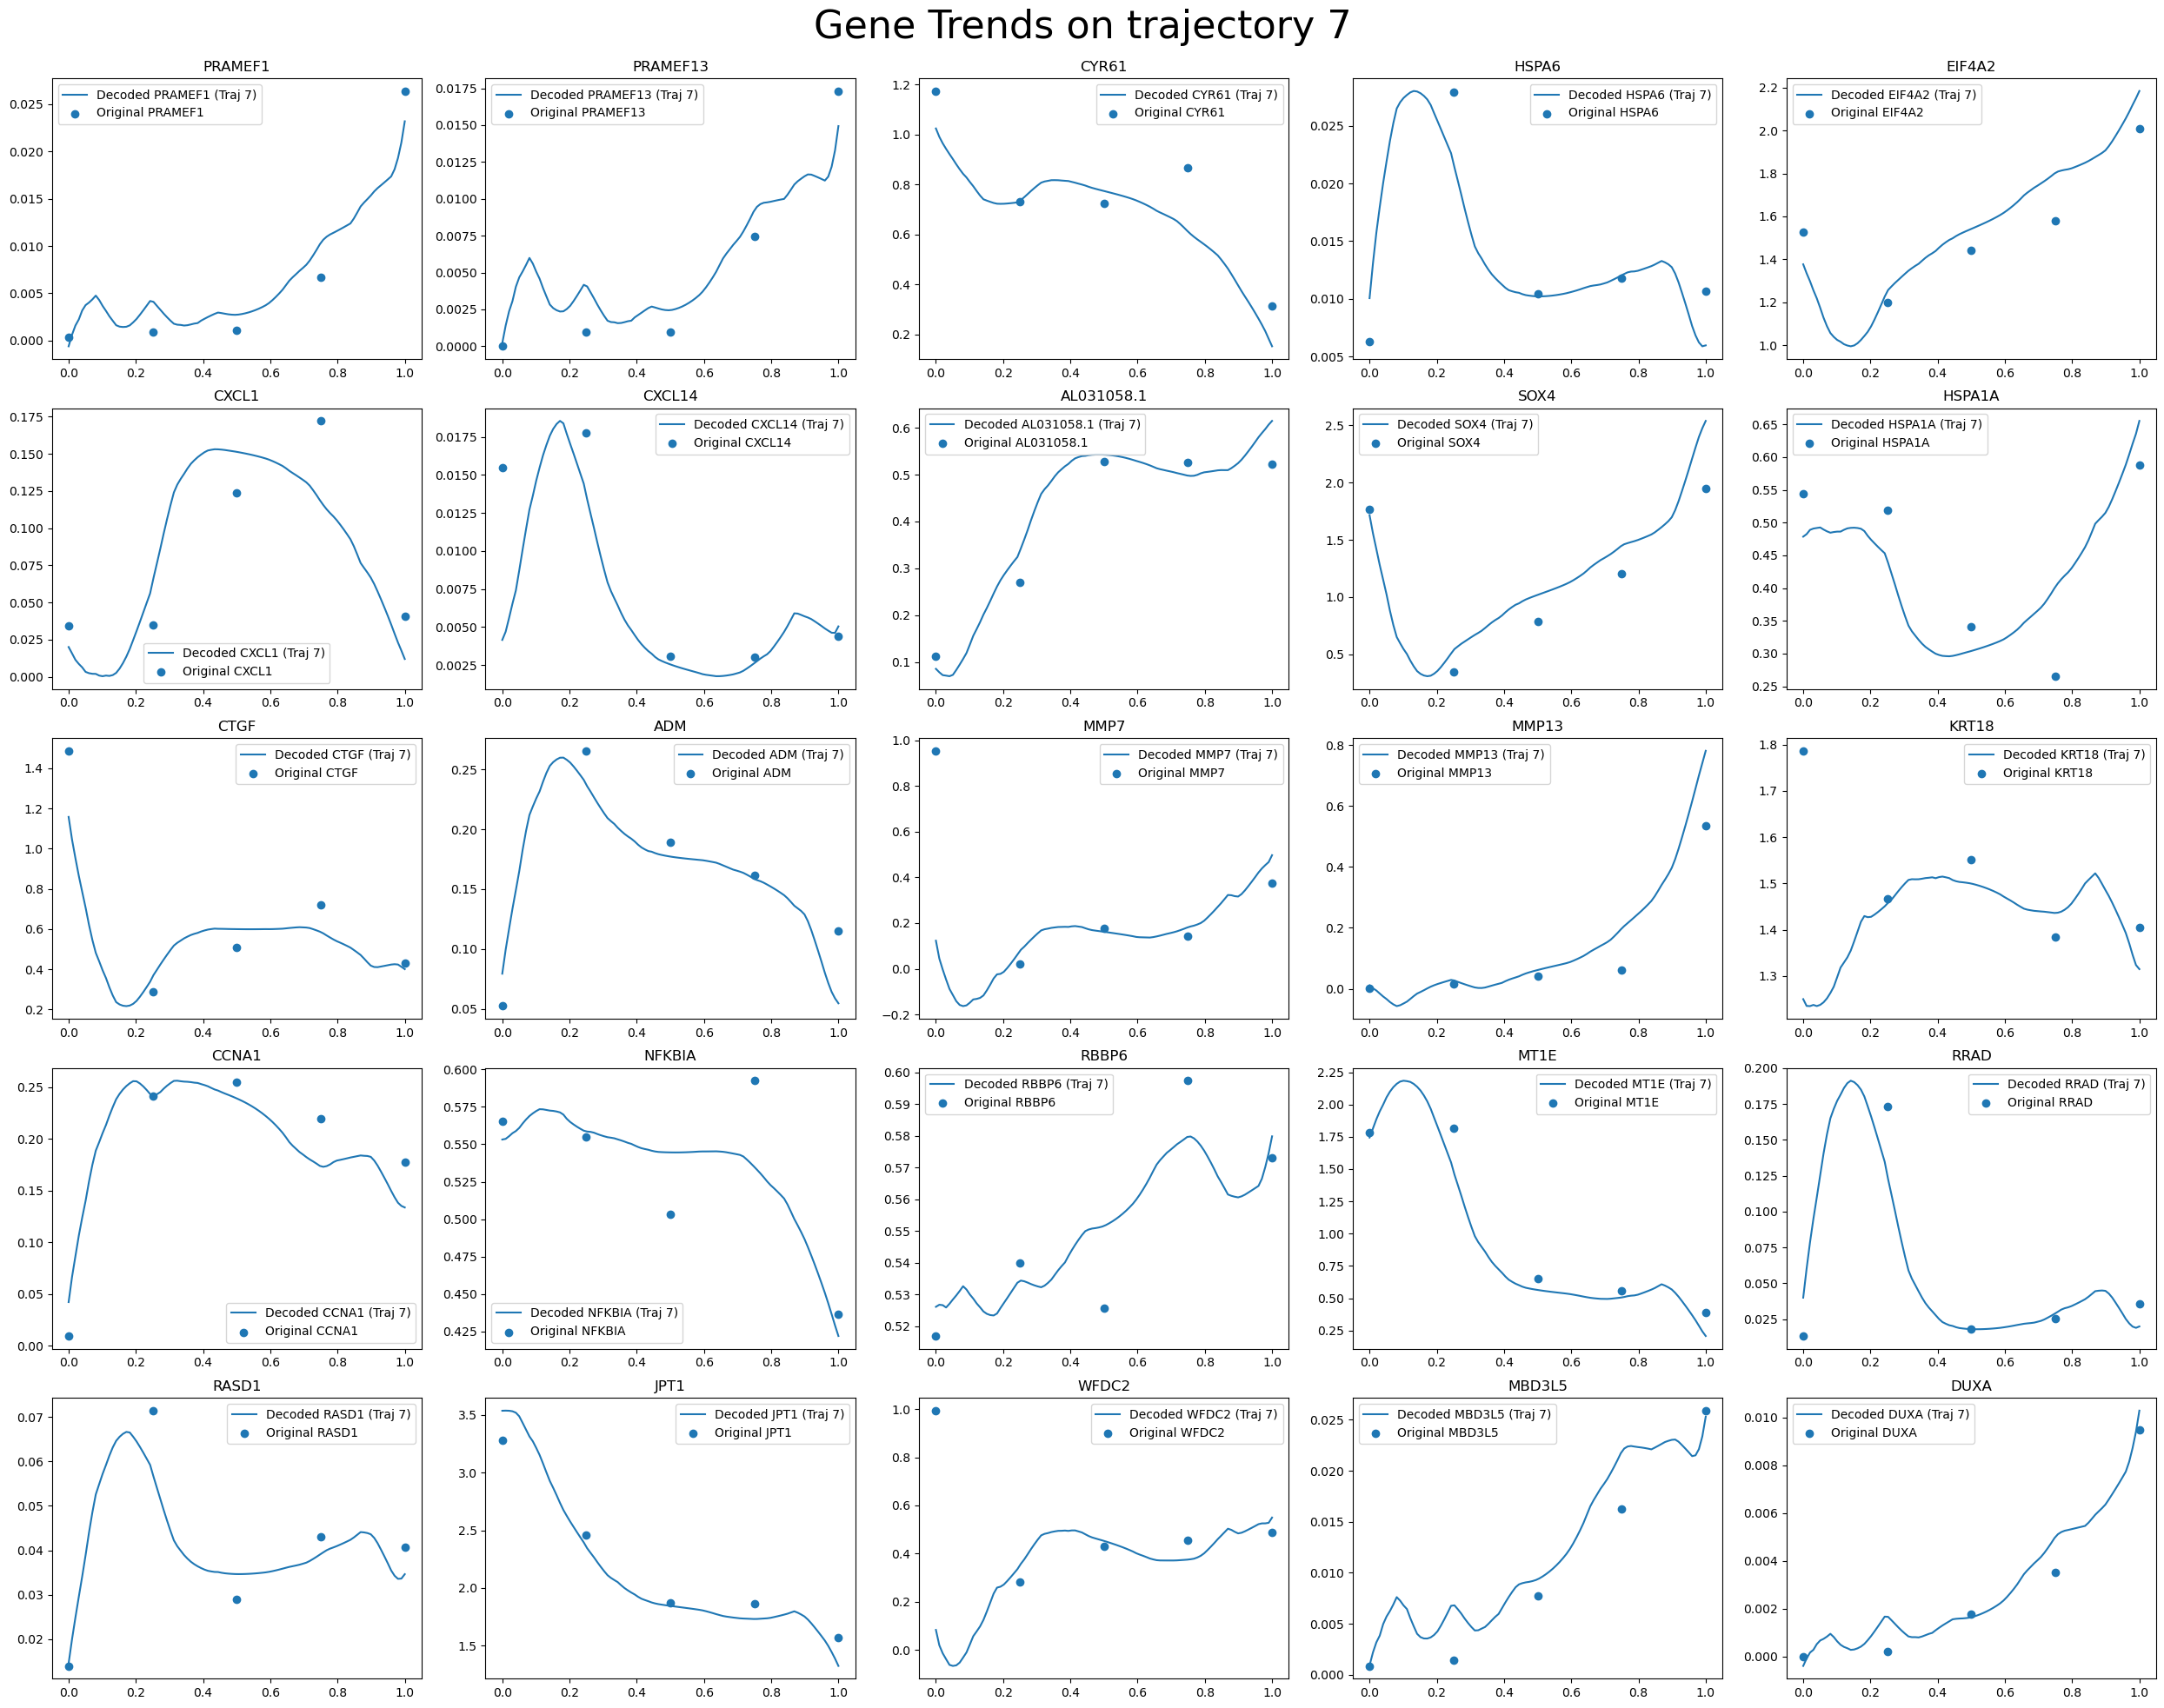

In [82]:
# Define which trajectory to highlight (you can set this to any trajectory index)

# Retrieving interest genes
adata_example_gene = adata[:, example_gene_mask]
decoded_example_gene = trajectories_gene_space[:, :, example_gene_mask]

# Extract the specific highlighted trajectory instead of computing mean/std across all trajectories
decoded_highlight_trajectory = decoded_example_gene[:, highlight_trajectory, :]

# Setting the y axis to be through the entire trajectory
x_time = np.linspace(0, 1, traj.shape[0])
x_time_data = adata_example_gene.obs['discrete_time']
x_time_data = (x_time_data - x_time_data.min()) / (x_time_data.max() - x_time_data.min())

# Filtering the data to only show the genes of interest
data_df = pd.DataFrame(adata_example_gene.X.toarray(), columns=example_genes, index=adata_example_gene.obs_names)
data_df['x_time'] = x_time_data
data_mean = data_df.groupby('x_time').mean()
data_std = data_df.groupby('x_time').std()

# Plotting all genes in a grid
# For this we need to know how many genes we have
n_genes = decoded_highlight_trajectory.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = int(np.ceil(n_genes / n_rows))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Finally, we plot each gene in a subplot
## The plots have the highlighted trajectory in blue (no variance shading since it's a single trajectory)
for i in range(n_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_highlight_trajectory[:,i], label=f'Decoded {example_genes[i].split("_Cycle")[-1]} (Traj {highlight_trajectory})')
    ax.scatter(data_mean.index, data_mean[example_genes[i]], label=f'Original {example_genes[i].split("_Cycle")[-1]}')
    ax.legend()
    ax.set_title(example_genes[i])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.94)  # Leave space at top
plt.suptitle(f'Gene Trends on trajectory {highlight_trajectory}', fontsize=32)  # Position suptitle in the space

plt.show()

## 6.2 Trajectory closer to the right endpoints

Target: (0.01, 0.018)
Selected trajectory 66 at (0.00, 0.02)


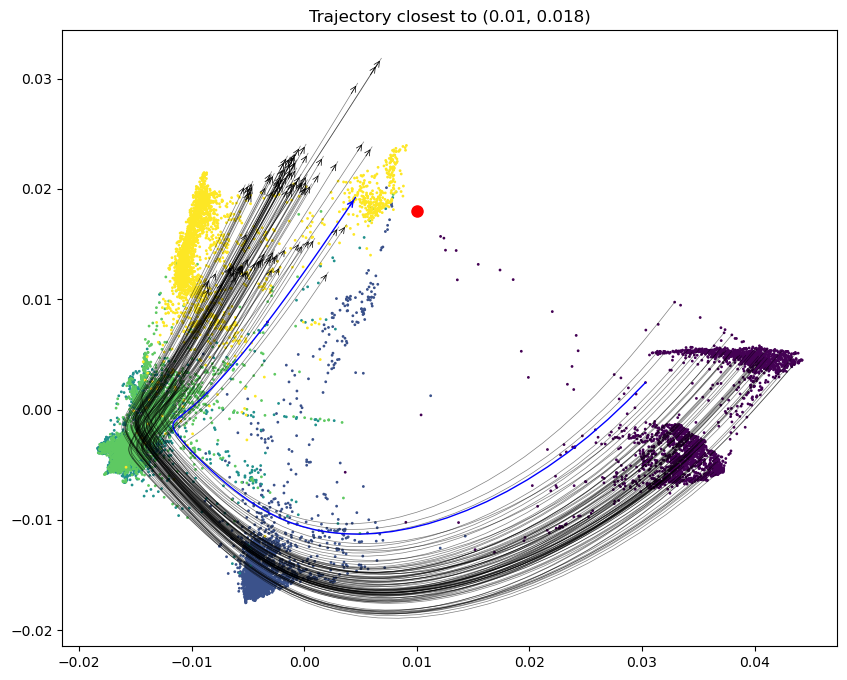

In [85]:
# Choose trajectory based on arrow's x and y coordinates
target_x = 0.01  # Target x-coordinate
target_y = 0.018 # Target y-coordinate

fig = plt.figure(figsize=(10, 8))
plt.scatter(true_data.values[:, 0], true_data.values[:, 1], 
           c=mioflow.df['samples'].values, cmap='viridis', s=1)

# Find trajectory with arrow closest to target point (target_x, target_y)
arrow_positions = []
distances = []
for i, traj in enumerate(np.transpose(trajectoriespts, axes=(1,0,2))):
    arrow_x = traj[-1, 0]  # x-coordinate of arrow (end point)
    arrow_y = traj[-1, 1]  # y-coordinate of arrow (end point)
    arrow_positions.append((arrow_x, arrow_y))
    
    # Calculate Euclidean distance to target point
    distance = np.sqrt((arrow_x - target_x)**2 + (arrow_y - target_y)**2)
    distances.append(distance)

# Find closest trajectory
highlight_trajectory = distances.index(min(distances))

print(f"Target: ({target_x}, {target_y})")
print(f"Selected trajectory {highlight_trajectory} at ({arrow_positions[highlight_trajectory][0]:.2f}, {arrow_positions[highlight_trajectory][1]:.2f})")

for i, traj in enumerate(np.transpose(trajectoriespts, axes=(1,0,2))):
    if i == highlight_trajectory:
        color = 'blue'
        linewidth = 1.0
        alpha = 1.0
    else:
        color = 'black'
        linewidth = 0.5
        alpha = 0.5
    
    plt.plot(traj[:, 0], traj[:, 1], alpha=alpha, linewidth=linewidth, color=color)
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle='->', color=color, lw=linewidth, mutation_scale=10))

# Mark target point
plt.plot(target_x, target_y, 'ro', markersize=8)
plt.title(f'Trajectory closest to ({target_x}, {target_y})')
plt.show()

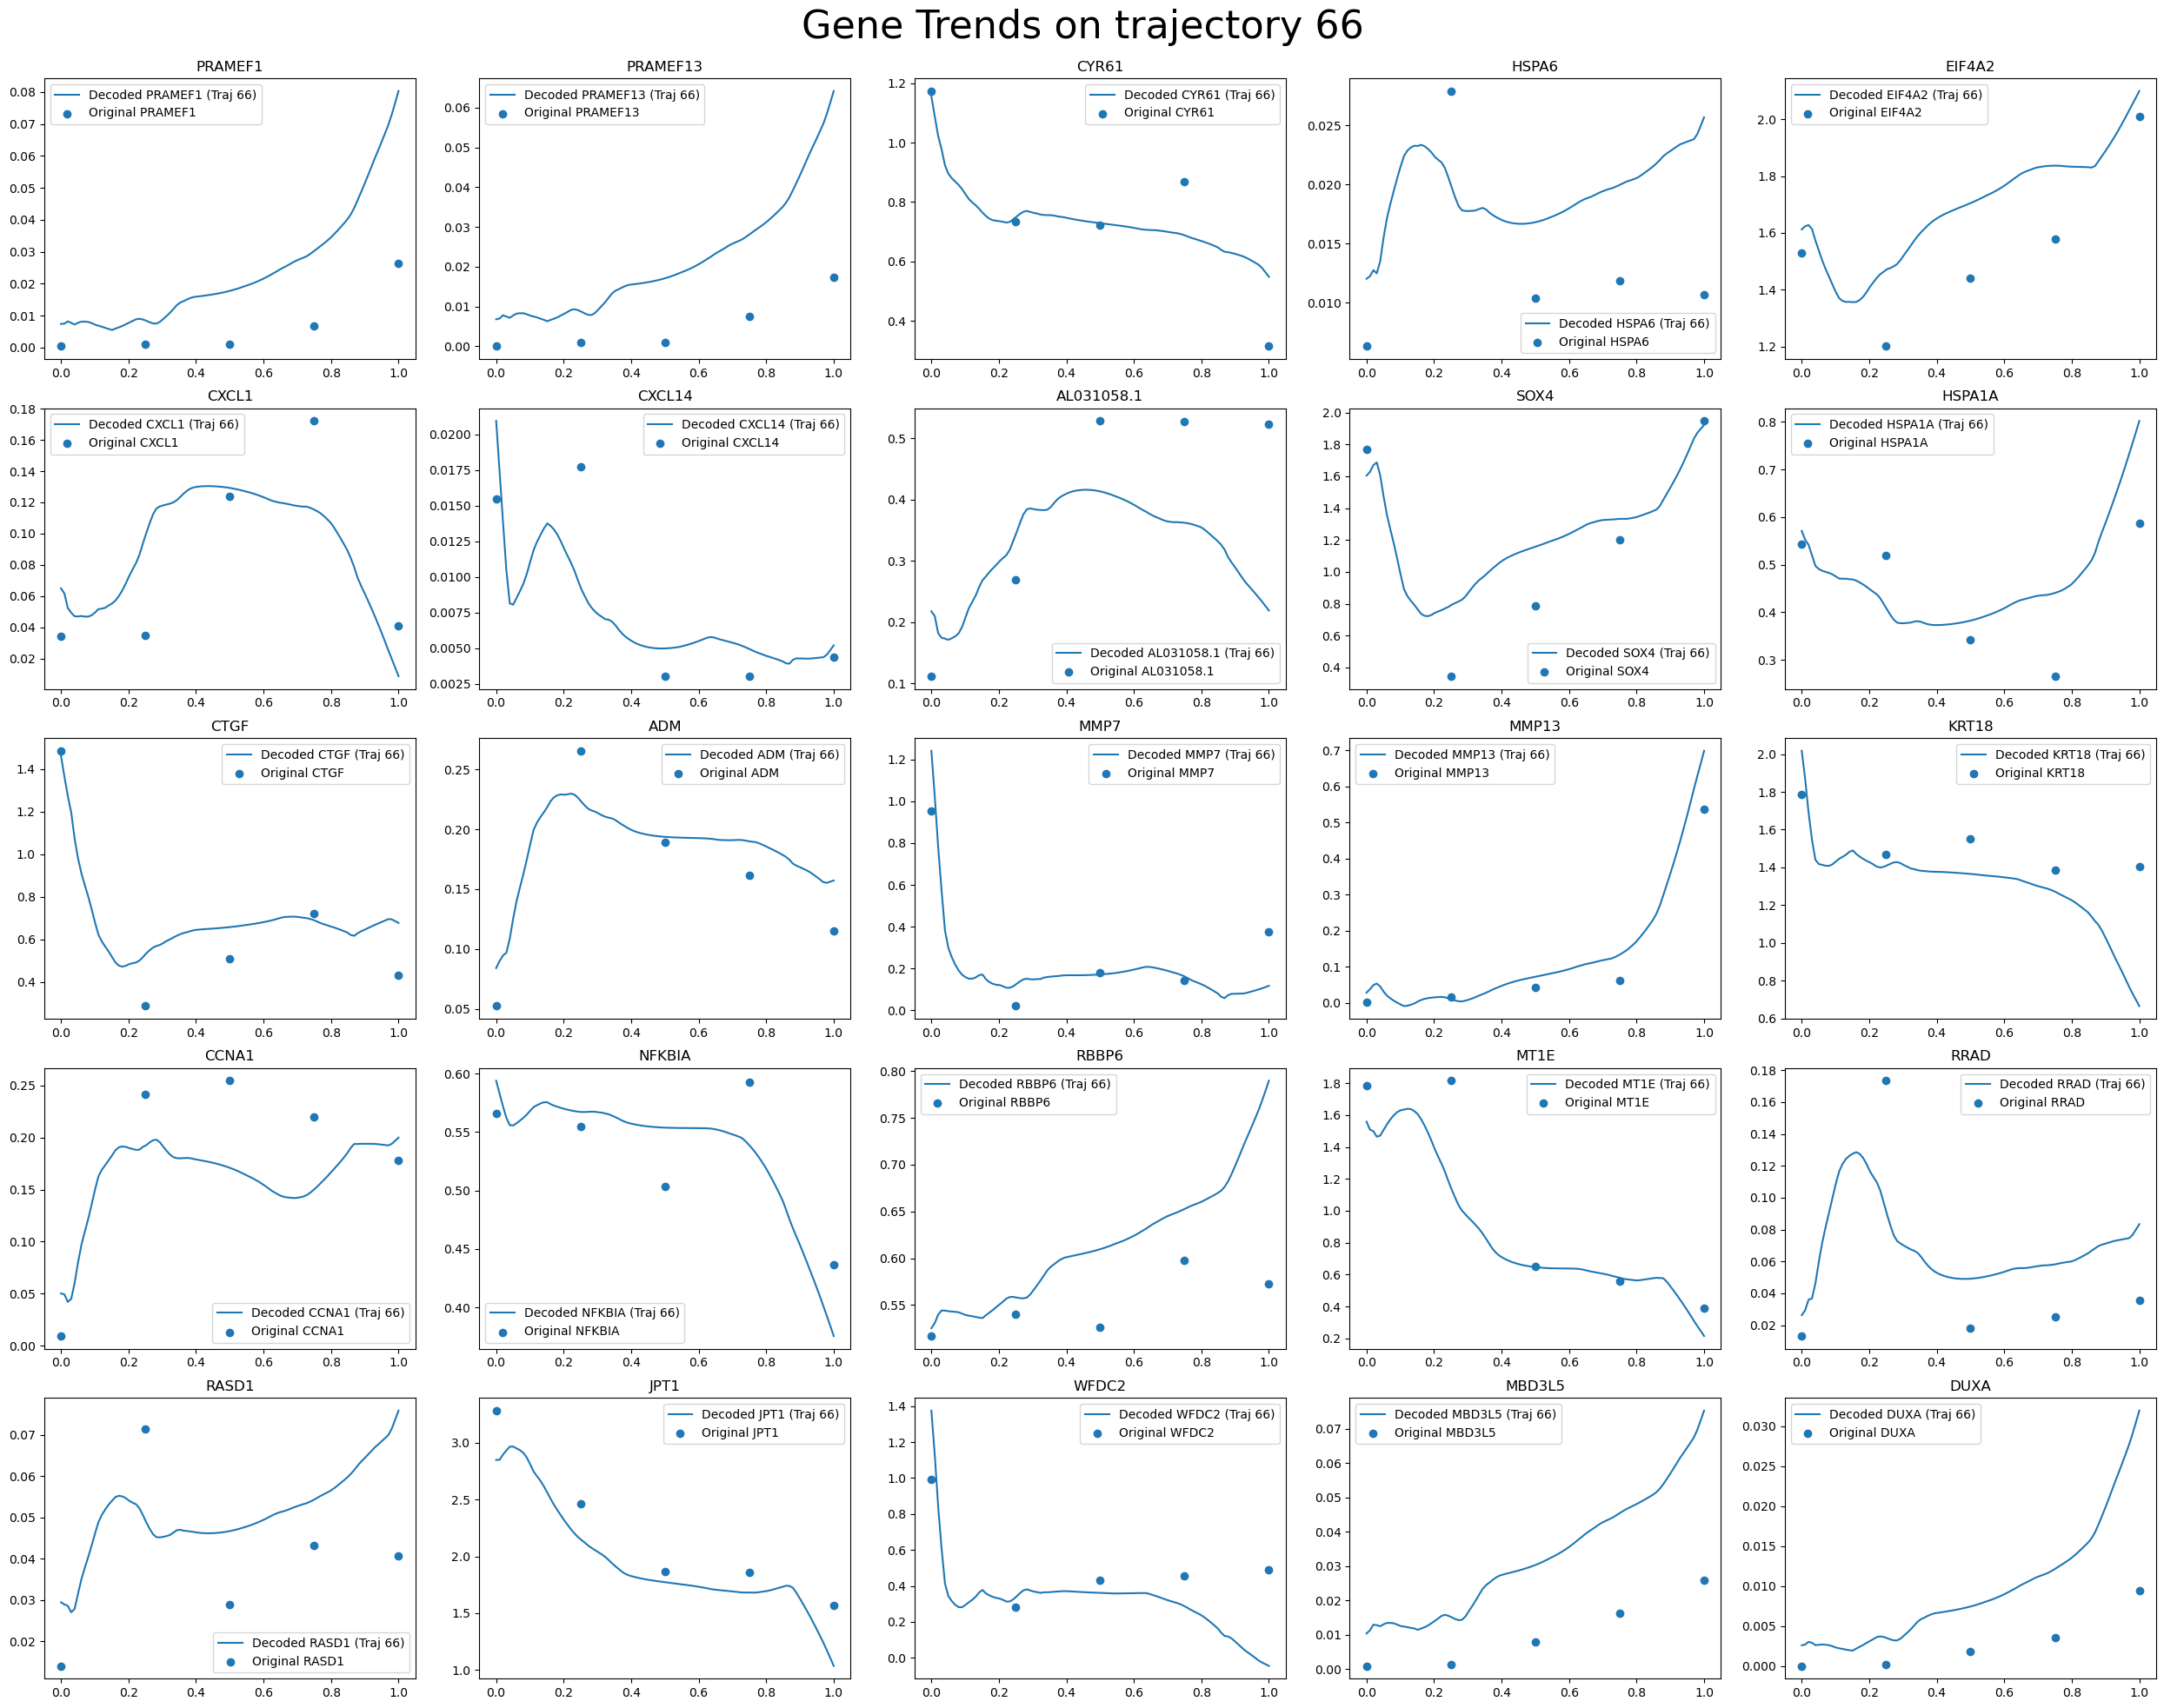

In [86]:
# Define which trajectory to highlight (you can set this to any trajectory index)

# Retrieving interest genes
adata_example_gene = adata[:, example_gene_mask]
decoded_example_gene = trajectories_gene_space[:, :, example_gene_mask]

# Extract the specific highlighted trajectory instead of computing mean/std across all trajectories
decoded_highlight_trajectory = decoded_example_gene[:, highlight_trajectory, :]

# Setting the y axis to be through the entire trajectory
x_time = np.linspace(0, 1, traj.shape[0])
x_time_data = adata_example_gene.obs['discrete_time']
x_time_data = (x_time_data - x_time_data.min()) / (x_time_data.max() - x_time_data.min())

# Filtering the data to only show the genes of interest
data_df = pd.DataFrame(adata_example_gene.X.toarray(), columns=example_genes, index=adata_example_gene.obs_names)
data_df['x_time'] = x_time_data
data_mean = data_df.groupby('x_time').mean()
data_std = data_df.groupby('x_time').std()

# Plotting all genes in a grid
# For this we need to know how many genes we have
n_genes = decoded_highlight_trajectory.shape[1]
n_rows = int(np.ceil(np.sqrt(n_genes)))
n_cols = int(np.ceil(n_genes / n_rows))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Finally, we plot each gene in a subplot
## The plots have the highlighted trajectory in blue (no variance shading since it's a single trajectory)
for i in range(n_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_highlight_trajectory[:,i], label=f'Decoded {example_genes[i].split("_Cycle")[-1]} (Traj {highlight_trajectory})')
    ax.scatter(data_mean.index, data_mean[example_genes[i]], label=f'Original {example_genes[i].split("_Cycle")[-1]}')
    ax.legend()
    ax.set_title(example_genes[i])
    
# Hide empty subplots
for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.94)  # Leave space at top
plt.suptitle(f'Gene Trends on trajectory {highlight_trajectory}', fontsize=32)  # Position suptitle in the space

plt.show()